# Iniciando a criação do meu primeiro modelo de machine learning
### Projeto de Iniciação Tecnológica
* Objetivo: Criar um modelo simples, verificar os resultados e ir complexando.
* Orientandos: Viviane Botelho, Thatiane Pianoschi, Bernardo Cecchetto

In [2]:
import tensorflow as tf
import keras as ke
import numpy as np
from matplotlib import pyplot as plt
import pathlib 
import os
import sklearn.metrics as skm 
import seaborn as sns
import pandas as pd
localImagens = pathlib.Path("/mnt/d/ImagensDatasetFredrik/imagensDataset/")

2023-03-22 17:30:54.538509: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Etapa 1: Criar um dataset a partir do diretório, redimensionar as imagens e separar em classes de positivo e negativo.
* Classe 0: Mamografias com diagnóstico NEGATIVO para a neoplasia
* Classe 1: Mamografias com diagnóstico POSITIVO para a neoplasia

In [3]:
#dataset = tf.keras.utils.image_dataset_from_directory(localImagens, 
#                                                      color_mode='grayscale', # colocamos em escala de cinza, assim ficamos com apenas 1 canal 
#                                                      shuffle=True,
#                                                      ) # embaralhar para dispersar os dados, possivelmente evitando bias

In [4]:
# Classes
#print(dataset.class_names)

In [5]:
# Quantidade de Imagens
quantImagens = len(list(pathlib.Path(localImagens).glob('*/*.png')))

In [6]:
# Outra forma de criar o conjunto de dados
listDataset = tf.data.Dataset.list_files(str(localImagens/'*/*'), shuffle=False)
listDataset = listDataset.shuffle(quantImagens, reshuffle_each_iteration=False)

2023-03-22 17:30:58.000601: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 17:30:58.001838: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
print("Quantidade de imagens: {0}".format(tf.data.experimental.cardinality(listDataset).numpy()))

Quantidade de imagens: 2015


In [8]:
class_names = np.array(sorted([item.name for item in localImagens.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

# https://www.tensorflow.org/tutorials/load_data/images?hl=pt-br 
# TESTANDO DO TENSOR FLOW
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [256, 256])

def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

['classe0' 'classe1']


### Definindo tamanho dos conjuntos de treino e validação

In [9]:
valSize = int(quantImagens * 0.3) # separando 20% para validação
testSize = int(quantImagens * 0.1) # separando 10% para teste
trainDataset = listDataset.skip(valSize+testSize)
valDataset = listDataset.take(valSize)
testDataset = listDataset.take(testSize)

In [10]:
# Verificando
print("Treino: {0}".format(str(tf.data.experimental.cardinality(trainDataset).numpy())))
print("Validacao: {0}".format(str(tf.data.experimental.cardinality(valDataset).numpy())))
print("Teste: {0}".format(str(tf.data.experimental.cardinality(testDataset).numpy())))

Treino: 1210
Validacao: 604
Teste: 201


In [11]:
# Cria o shape (imagem, label)
AUTOTUNE = tf.data.AUTOTUNE # PROCESSAR/CARREGAR AS IMAGENS EM PARALELO
trainDataset = trainDataset.map(process_path, num_parallel_calls=AUTOTUNE)
valDataset = valDataset.map(process_path, num_parallel_calls=AUTOTUNE)
testDataset = testDataset.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
# Tentando criar os tensores
# Estou com dificuldades...

train_Images = []
train_Labels = []
for images, labels in trainDataset.take(-1):  
    train_Images.append(images.numpy())
    train_Labels.append(labels.numpy())

val_Images = []
val_Labels = []
for images, labels in valDataset.take(-1):  
    val_Images.append(images.numpy())
    val_Labels.append(labels.numpy())

In [13]:
# Passar para numpy array
X_train = np.array(train_Images)
Y_train = np.array(train_Labels)
X_val = np.array(val_Images)
Y_val = np.array(val_Labels)
print(X_train.shape)
print(Y_train.shape)

(1210, 256, 256, 3)
(1210,)


### Vamo tentar normalizar para ver se muda algo

In [14]:
X_train = X_train/255.0
X_val = X_val/255.0

### Criando Modelo

In [15]:
tf.random.set_seed(7569)
np.random.seed(7569)

model = ke.Sequential()
model.add(ke.layers.Flatten(input_shape=X_train[0].shape))
model.add(ke.layers.Dense(64, activation='relu'))
model.add(ke.layers.Dense(2, activation='softmax')) # softmax para problemas multiclasse
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense (Dense)               (None, 64)                12582976  
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 12,583,106
Trainable params: 12,583,106
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Otimizador
opt = tf.optimizers.Adam(learning_rate=1e-4)

# Criterio de parada
stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# Compilando modelo
model.compile(optimizer=opt,loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [17]:
# Treinando modelo
history = model.fit(x=X_train,
                    y=Y_train,
                    batch_size=100,
                    epochs=40,
                    validation_data=(X_val,Y_val), callbacks=[stop]);

Epoch 1/40
13/13 [==============================] - 4s 255ms/step - loss: 3.6268 - accuracy: 0.5124 - val_loss: 1.6886 - val_accuracy: 0.4950
Epoch 2/40
13/13 [==============================] - 2s 149ms/step - loss: 0.9736 - accuracy: 0.5157 - val_loss: 0.6896 - val_accuracy: 0.5480
Epoch 3/40
13/13 [==============================] - 2s 160ms/step - loss: 0.6975 - accuracy: 0.5719 - val_loss: 0.8418 - val_accuracy: 0.5033
Epoch 4/40
13/13 [==============================] - 2s 144ms/step - loss: 0.7089 - accuracy: 0.5653 - val_loss: 0.6882 - val_accuracy: 0.5563
Epoch 5/40
13/13 [==============================] - 2s 138ms/step - loss: 0.7065 - accuracy: 0.5777 - val_loss: 0.9433 - val_accuracy: 0.4950
Epoch 6/40
13/13 [==============================] - 2s 150ms/step - loss: 0.6779 - accuracy: 0.6132 - val_loss: 0.7006 - val_accuracy: 0.5364
Epoch 7/40
13/13 [==============================] - 2s 131ms/step - loss: 0.5605 - accuracy: 0.7298 - val_loss: 0.7076 - val_accuracy: 0.5447
Epoch 

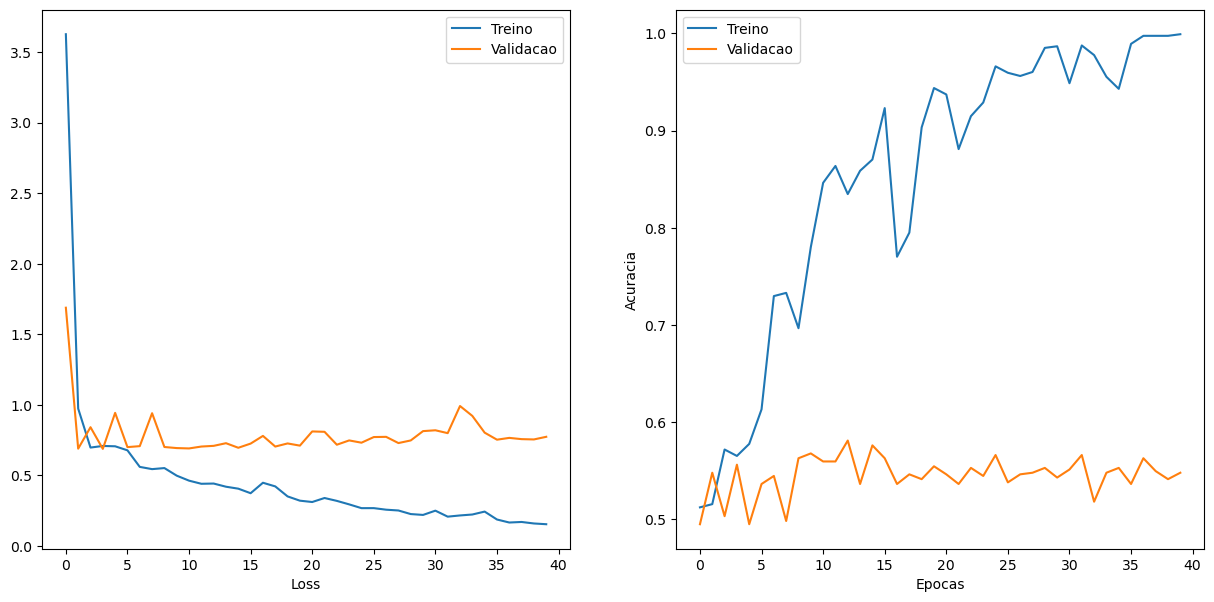

In [18]:
plt.figure(figsize=(15,7))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validacao')
plt.xlabel('Epocas')
plt.xlabel('Loss')
plt.legend();
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validacao')
plt.xlabel("Epocas")
plt.ylabel("Acuracia")
plt.legend();

In [19]:
# Pegando codigo da prof vivi
def mat_conf_multi(Xmedido, ymedido, model,nome_dados):
    Y_pred_prob = model.predict(Xmedido)
    Y_pred = np.argmax(Y_pred_prob,axis=1) 
    cmat=skm.confusion_matrix(ymedido,Y_pred)
    cm_df = pd.DataFrame(cmat) 

    ax= plt.subplot()
    sns.heatmap(cm_df,annot=True, cmap='Blues',fmt="d",cbar=False)

    ax.set_xlabel('Predito');ax.set_ylabel('Real'); 
    ax.set_title('Matriz de confusão:'+nome_dados); 
    return

19/19 [==============================] - 0s 18ms/step


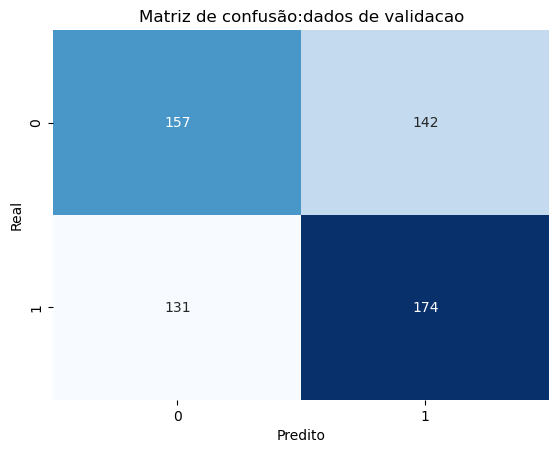

In [20]:
mat_conf_multi(X_val, Y_val, model,'dados de validacao')